In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np

np.random.seed(0)

import torch

torch.manual_seed(0)
torch.set_default_dtype(torch.double)

import gpytorch

import sys

sys.path.append("../")

from utils.constants import CATS, ANS, FEATURES, TARGET_NOISE, TARGET

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm import tqdm
import wandb

track_wandb = False

In [2]:
cols = CATS + ANS + FEATURES + [TARGET_NOISE, TARGET]
num_dims = len(CATS) + len(ANS)

df = pd.read_csv("../data/free_energies_031522.csv")[cols]

train_x = df[cols[:-2]].values
train_x = torch.tensor(train_x).double()

noise_train = df[cols[-2]].values
noise_train = torch.tensor(noise_train)

train_y = df[cols[-1]].values
train_y = torch.tensor(train_y)

mean_y = train_y.mean().item()
std_y = train_y.std().item()

train_y = (train_y - mean_y) / std_y
unnormalize_fn = lambda x: (x * std_y + mean_y, x * std_y)

In [3]:
mean_y, std_y

(36.289183542903224, 18.01857291323604)

In [4]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # self.mean_module = CustomLinearMean()
        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x[:, num_dims:])
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
lengthscale = 0.01
outputscale = 3000

learn_additional_noise = False
noise_upperbound = 1

likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(
    noise=(noise_train / std_y) ** 2, 
    learn_additional_noise=learn_additional_noise,
    noise_constraint=gpytorch.constraints.LessThan(noise_upperbound) if learn_additional_noise else None
)

model = GPModel(train_x, train_y, likelihood)
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.covar_module.base_kernel.raw_lengthscale.requires_grad_(False)
model.covar_module.raw_outputscale.requires_grad_(False)

Parameter containing:
tensor(3000.)

In [6]:
try:
    print(
        model.mean_module.weight.item(),
        model.mean_module.bias.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )
except AttributeError:
    print(
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )

3000.0 [[0.01]]


In [7]:
num_iters = 2000

# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

for i in tqdm(range(num_iters)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    
    if track_wandb:
        log_dict = {}
        log_dict["iter"] = i
        log_dict["loss"] = loss.item()
        log_dict["weight"] = model.mean_module.weight.item()
        log_dict["bias"] = model.mean_module.bias.item()
        log_dict["output scale"] = model.covar_module.outputscale.item()
        lengthscales = model.covar_module.base_kernel.lengthscale.detach().numpy().flatten().tolist()
        for l_ind, l in enumerate(lengthscales):
            log_dict[f"length scale {l_ind + 1}"] = l
        wandb_run.log(log_dict)

    optimizer.step()

model.eval()
likelihood.eval()

# plt.figure(figsize=(8, 6))
# plt.plot(losses);

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
100%|██████████| 2000/2000 [00:02<00:00, 825.41it/s]


FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

In [13]:
try:
    print(
        model.mean_module.weight.item(),
        model.mean_module.bias.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )
except AttributeError:
    print(
        model.mean_module.constant.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
    )

14.716128627738737 3000.0 [[0.01]]


# inference

In [9]:
from utils.plotting import plot_regressor_square_edges, plot_regressor_square

In [10]:
test_cols = CATS + ANS + FEATURES
space_df = pd.read_csv("../data/space_w_feats.csv")[test_cols]

test_x = torch.tensor(space_df.values).double()
test_x.shape

torch.Size([3481, 7])

/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussi

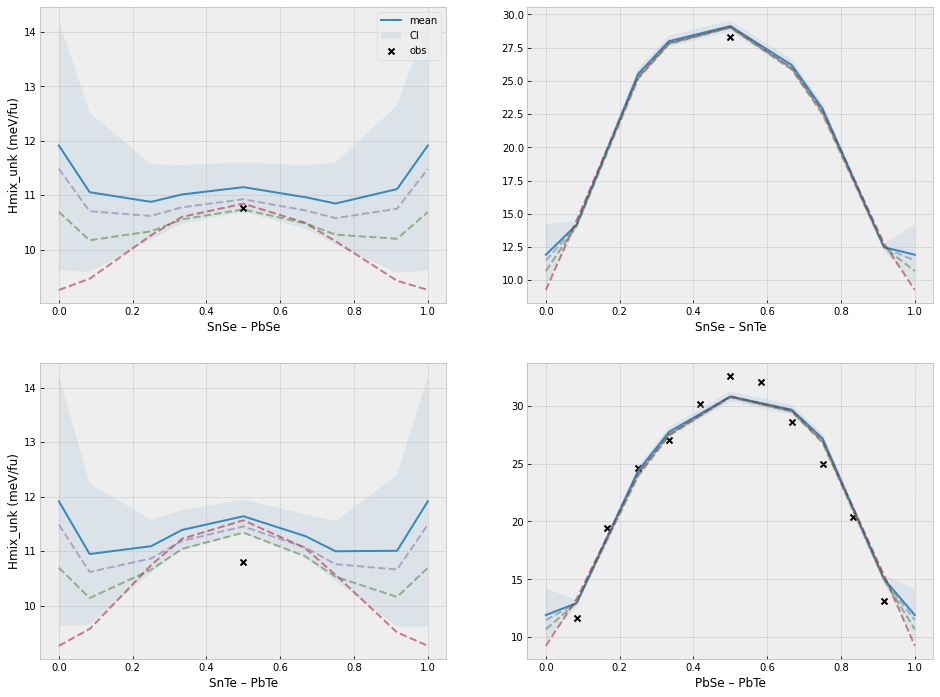

In [11]:
cat_ind1 = 0
cat_ind2 = 1
an_ind1 = 3
an_ind2 = 4

fig, ax = plot_regressor_square_edges(
    cat_ind1,
    cat_ind2,
    an_ind1,
    an_ind2,
    model,
    likelihood,
    train_x,
    train_y,
    test_x,
    unnormalize_fn=unnormalize_fn,
)

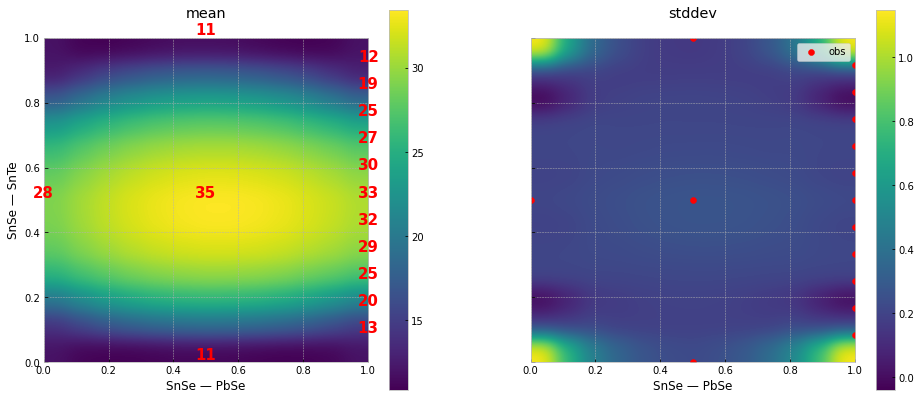

In [12]:
plot_regressor_square(
    cat_ind1,
    cat_ind2,
    an_ind1,
    an_ind2,
    model,
    likelihood,
    train_x,
    train_y,
    test_x,
    unnormalize_fn=unnormalize_fn,
)

/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch

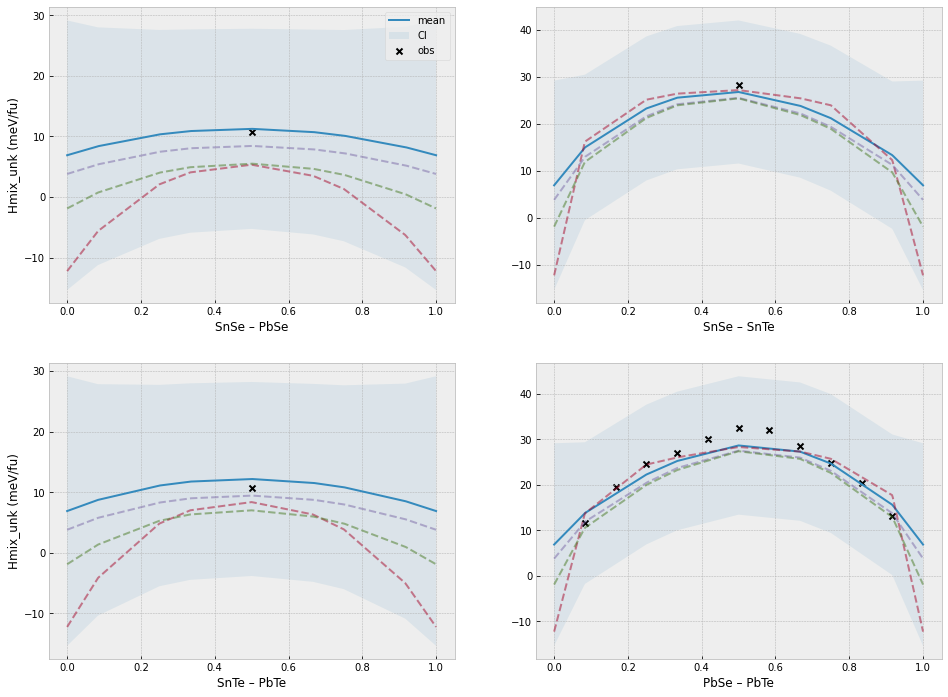

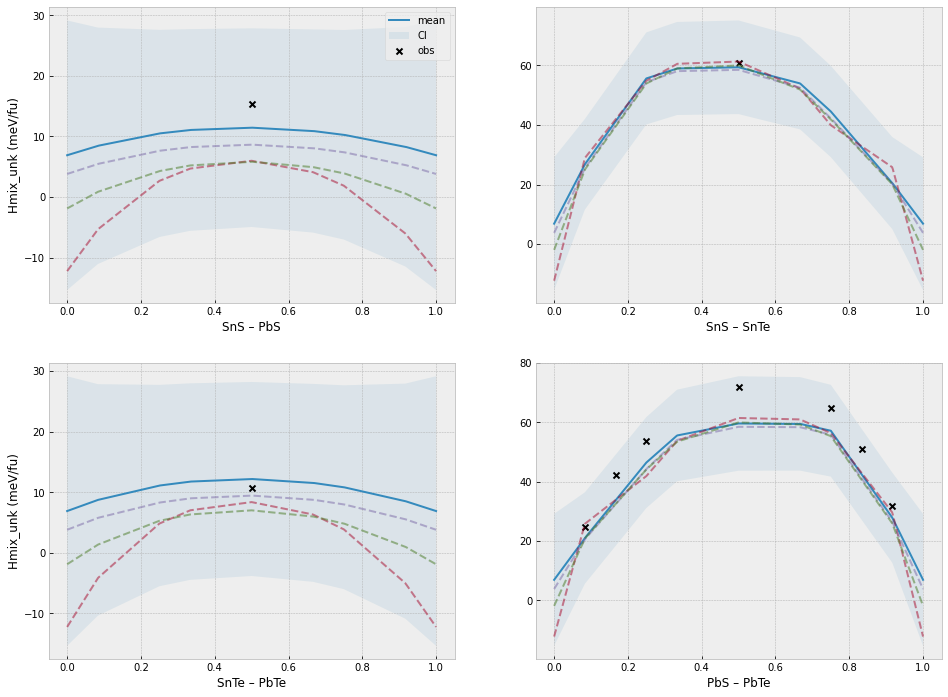

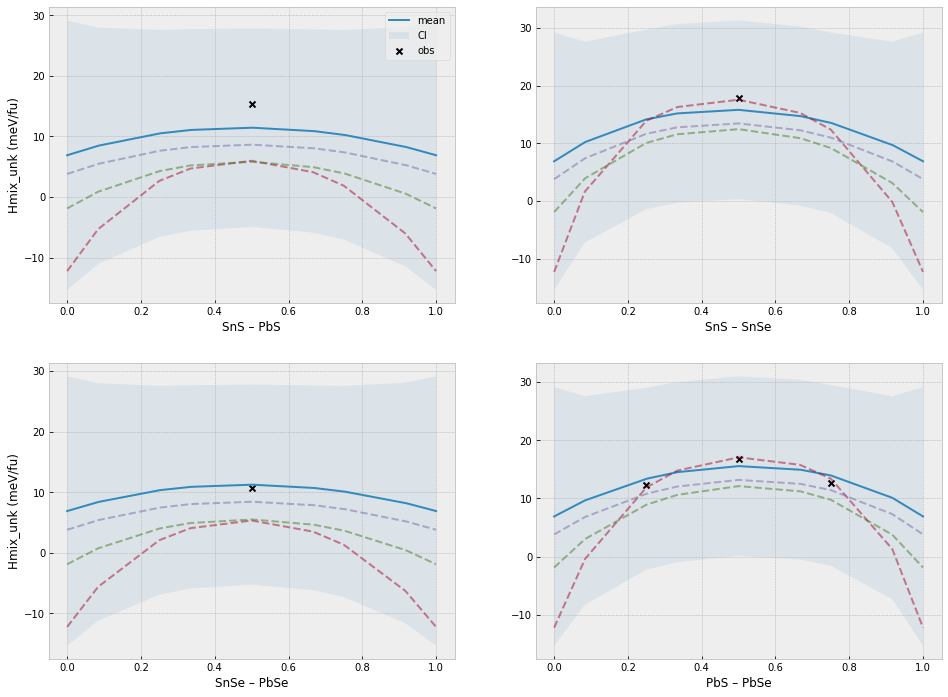

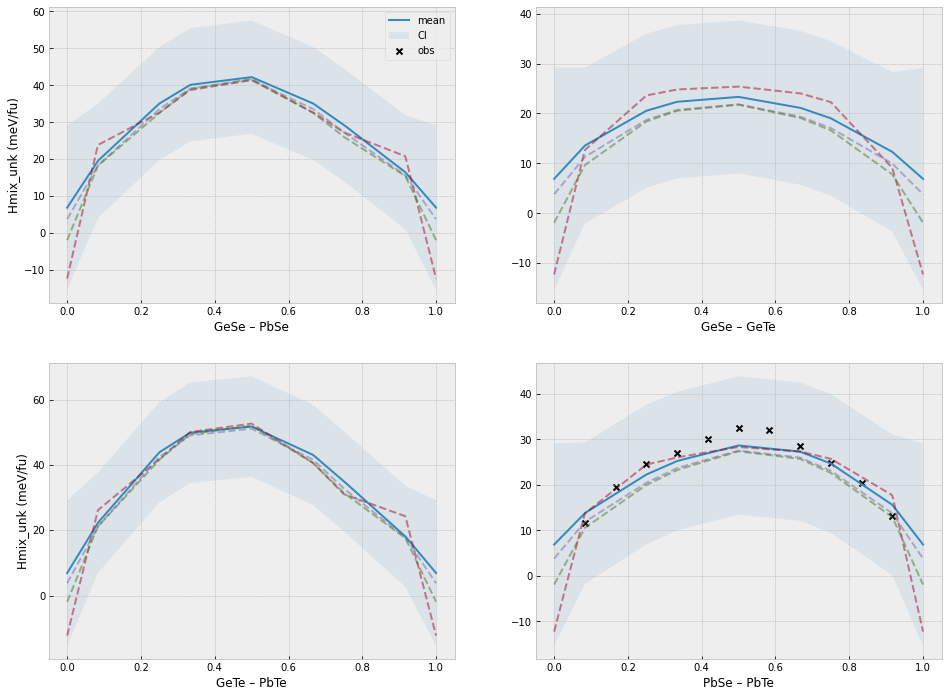

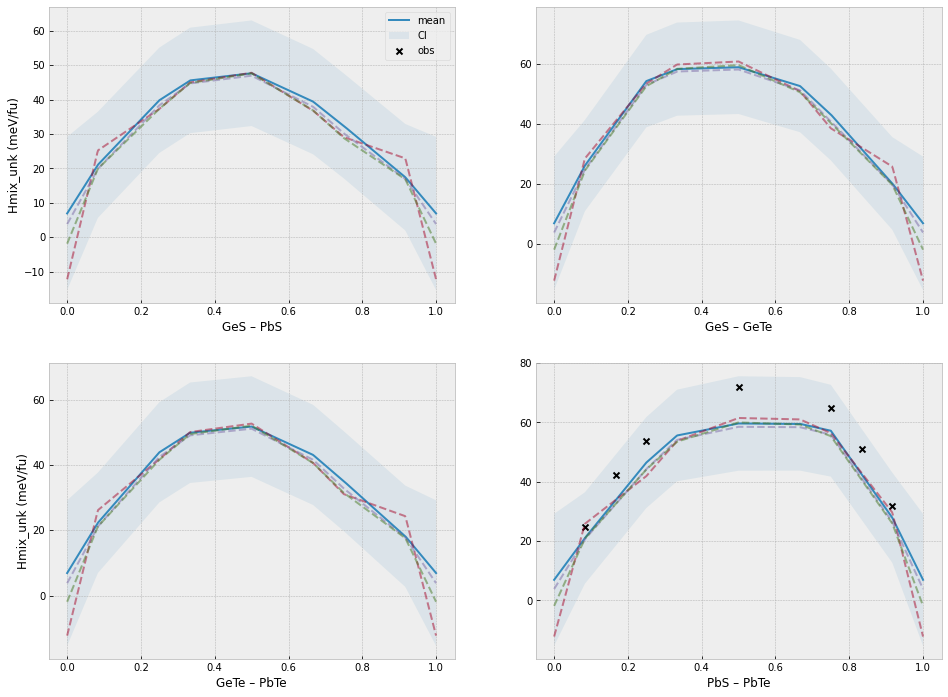

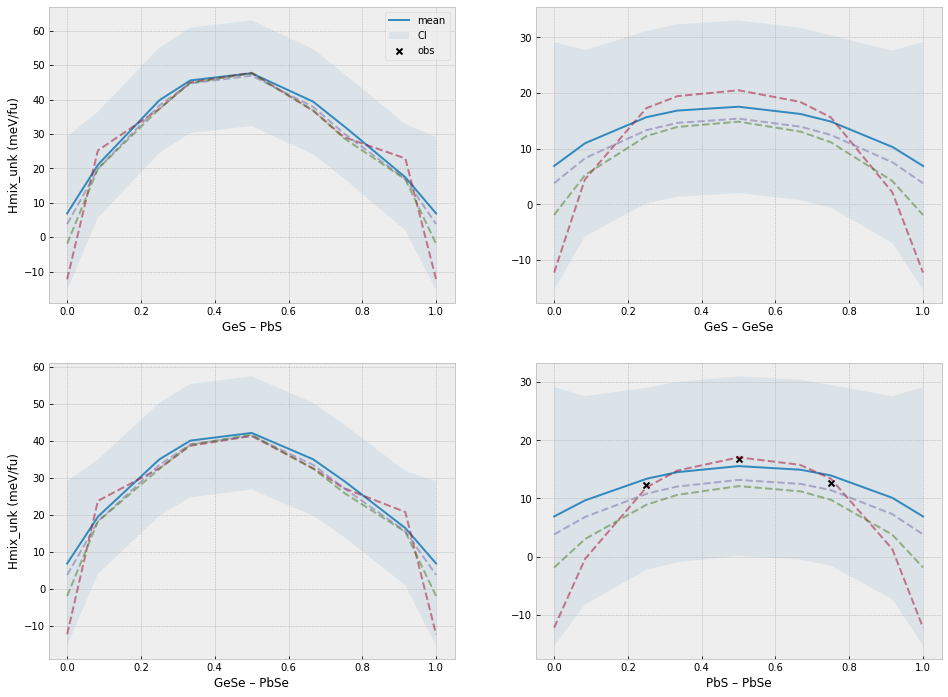

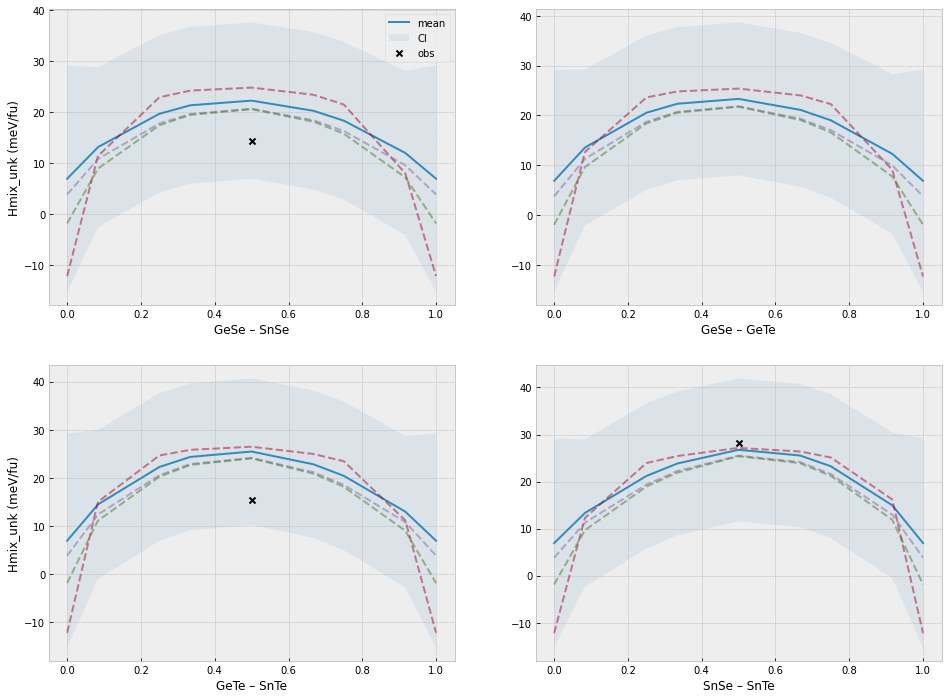

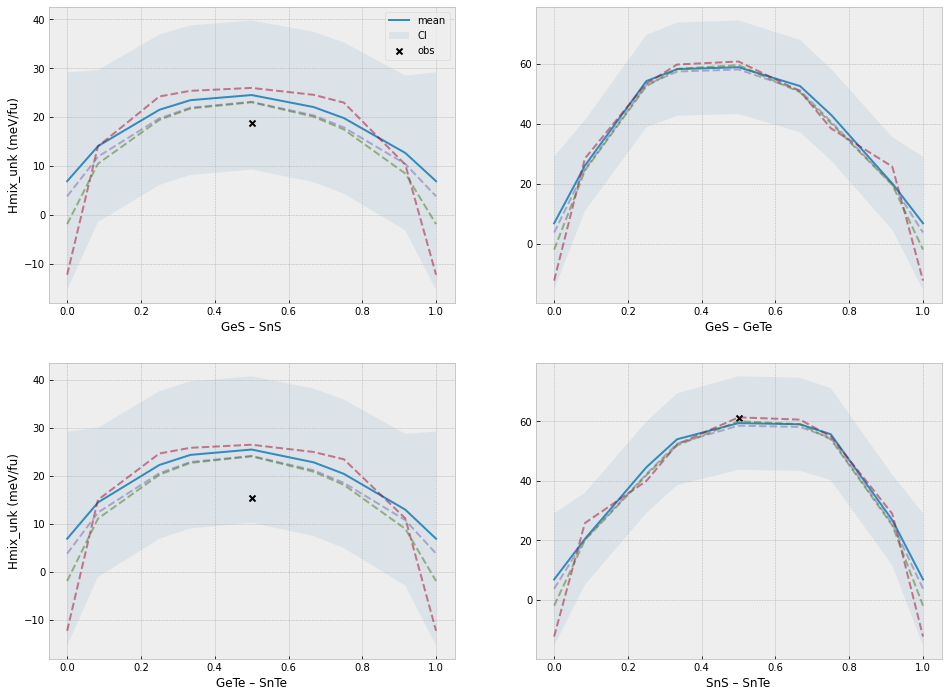

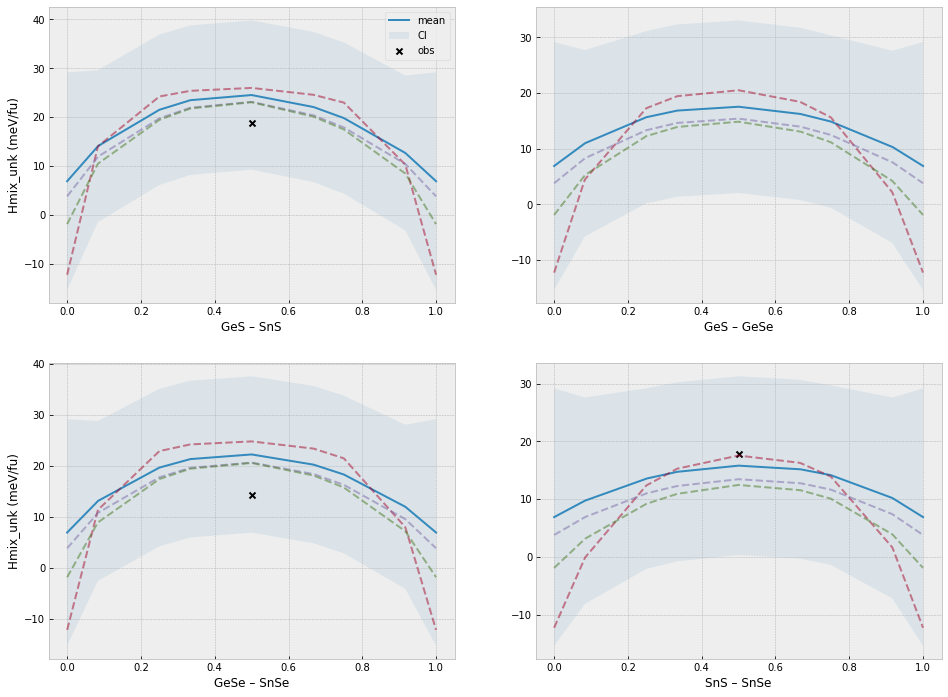

In [13]:
for cat_ind1 in range(2):
    for cat_ind2 in range(cat_ind1 + 1, 3):
        for an_ind1 in range(3, 5):
            for an_ind2 in range(an_ind1 + 1, 6):
                fig, ax = plot_regressor_square_edges(
                    cat_ind1,
                    cat_ind2,
                    an_ind1,
                    an_ind2,
                    model,
                    likelihood,
                    train_x,
                    train_y,
                    test_x,
                    unnormalize_fn=unnormalize_fn,
                )
                
                if track_wandb:
                    wandb_run.log(
                        {f"{CATS[cat_ind1]}{CATS[cat_ind2]}{ANS[an_ind1 - len(CATS)]}{ANS[an_ind2 - len(CATS)]}": wandb.Image(plt)}
                    )

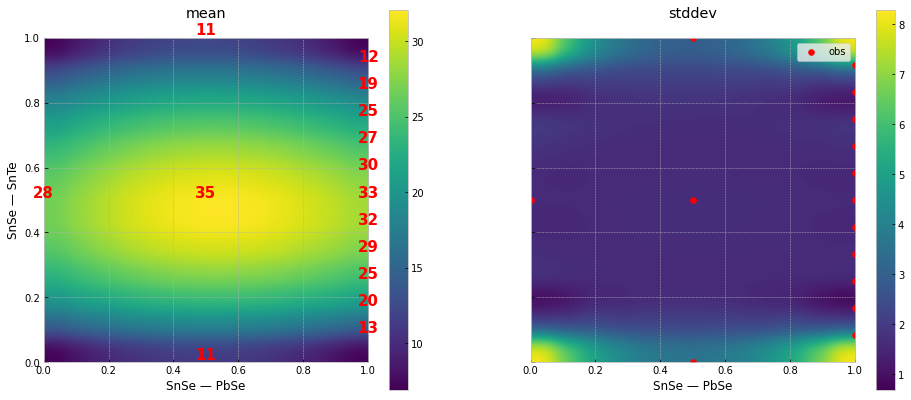

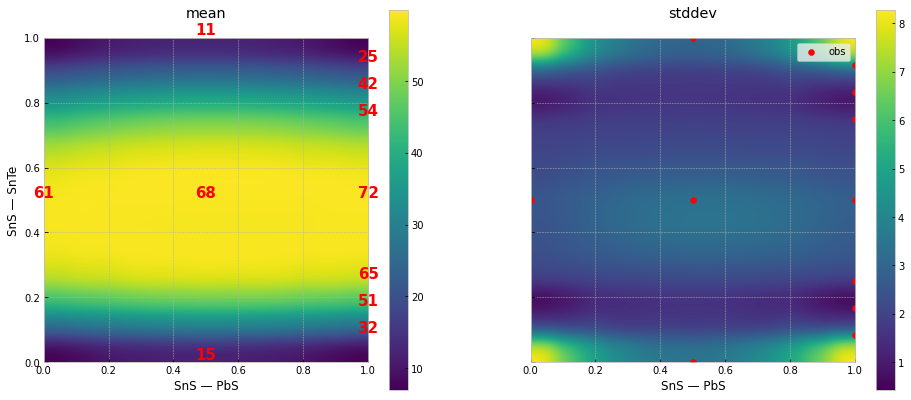

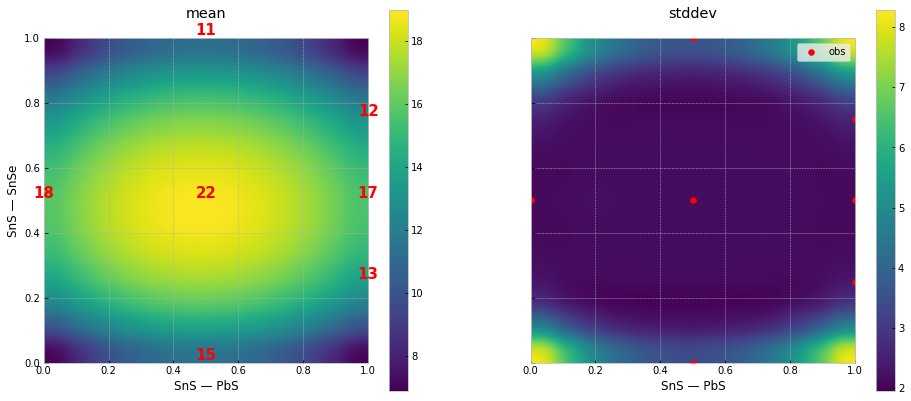

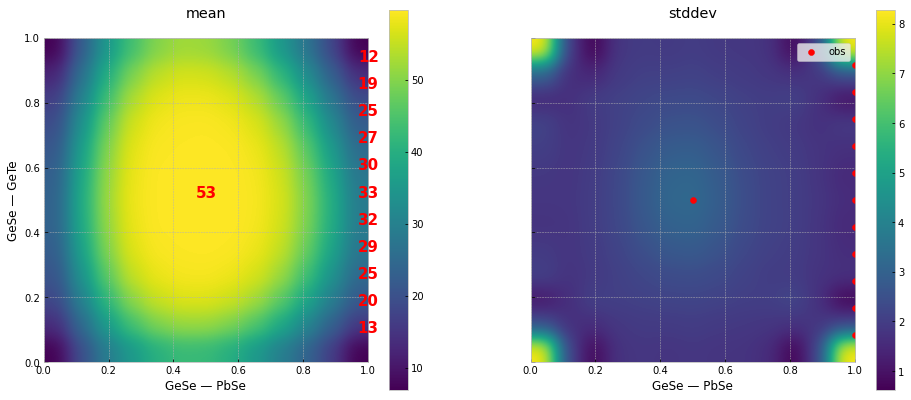

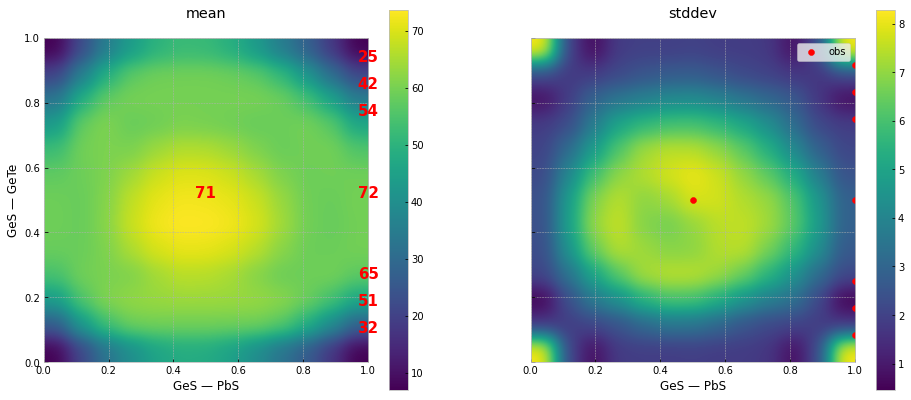

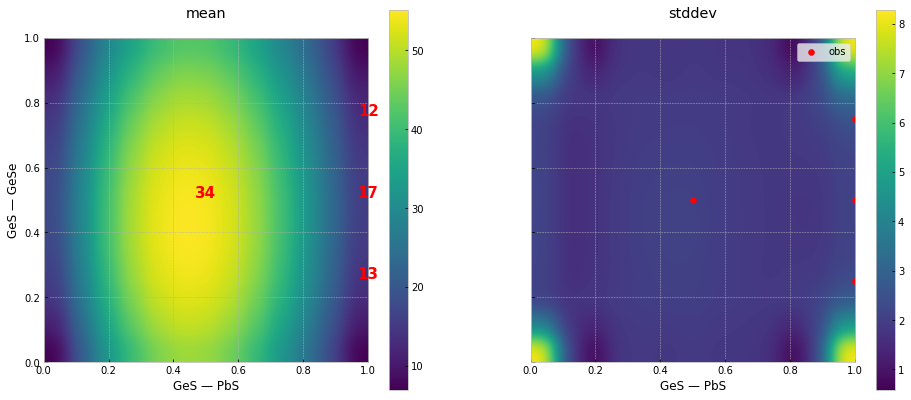

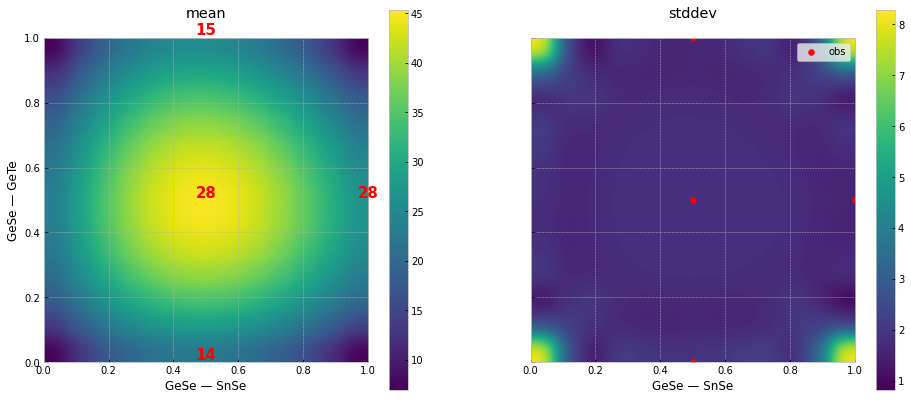

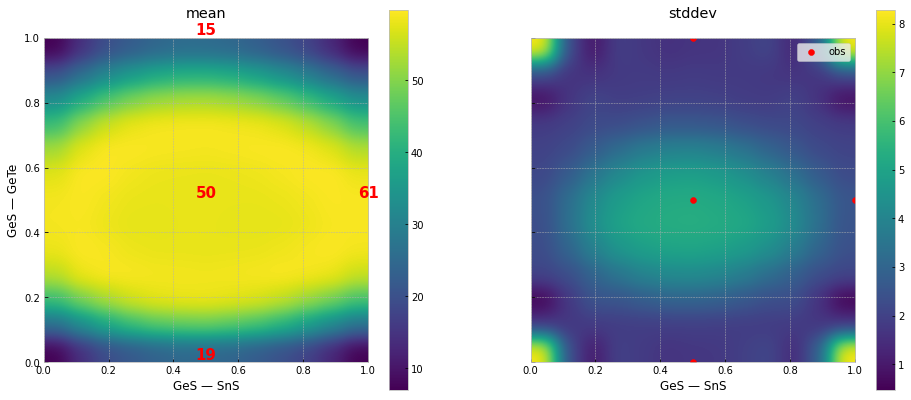

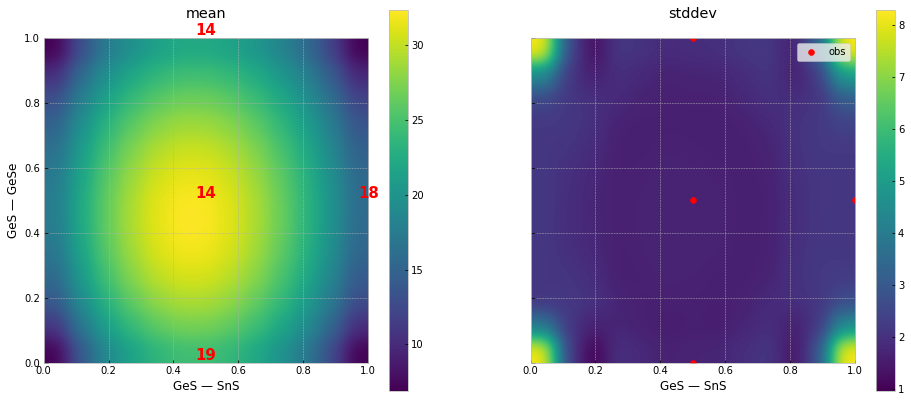

In [14]:
for cat_ind1 in range(2):
    for cat_ind2 in range(cat_ind1 + 1, 3):
        for an_ind1 in range(3, 5):
            for an_ind2 in range(an_ind1 + 1, 6):
                plot_regressor_square(
                    cat_ind1,
                    cat_ind2,
                    an_ind1,
                    an_ind2,
                    model,
                    likelihood,
                    train_x,
                    train_y,
                    test_x,
                    unnormalize_fn=unnormalize_fn,
                )